## Item-Based Collaborative Filtering.

Elias Ejo, 12/10/2022

## Step 1: Import Python Libraries

In [1]:
# Data processing
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Similarity
from sklearn.metrics.pairwise import cosine_similarity

# Label encoder 
from sklearn import preprocessing

# Surprise builder and analyzer
from surprise import reader as sr
from surprise import dataset as sd
from surprise import KNNBasic
from surprise import BaselineOnly
from surprise import accuracy
from surprise.model_selection import cross_validate
from surprise.model_selection import train_test_split

import operator

%matplotlib inline

## Step 2 : Loading and Exploratory Data Analysis on BX-Books dataset

### 2.1: Load the dataset

In [2]:
# Read BX-Book dataset from file into book_df
book_df = pd.read_csv("BX-Books.csv", low_memory=False, encoding='latin-1')

book_df is a variable which will store the data read by the csv file.


In [3]:
# Print first 5 rows of the dataset
book_df.head()

,isbn,book_title,book_author,year_of_publication,publisher
0,195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press
1,2005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada
2,60973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial
3,374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux
4,393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company


In [4]:
# Print last 5 rows of the dataset
book_df.tail()

,isbn,book_title,book_author,year_of_publication,publisher
271374,440400988,There's a Bat in Bunk Five,Paula Danziger,1988,Random House Childrens Pub (Mm)
271375,525447644,From One to One Hundred,Teri Sloat,1991,Dutton Books
271376,006008667X,Lily Dale : The True Story of the Town that Ta...,Christine Wicker,2004,HarperSanFrancisco
271377,192126040,Republic (World's Classics),Plato,1996,Oxford University Press
271378,767409752,A Guided Tour of Rene Descartes' Meditations o...,Christopher Biffle,2000,McGraw-Hill Humanities/Social Sciences/Languages


### 2.2: Understand the dataset

In [5]:
# Check the size of the dataset
book_df.shape

(271379, 5)

Observation:
* The dataset has 271,379 rows and 5 columns

In [6]:
# Print detail information about the dataframe
book_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271379 entries, 0 to 271378
Data columns (total 5 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   isbn                 271379 non-null  object
 1   book_title           271379 non-null  object
 2   book_author          271378 non-null  object
 3   year_of_publication  271379 non-null  object
 4   publisher            271377 non-null  object
dtypes: object(5)
memory usage: 10.4+ MB


Observation: 
* There are 5 columns in the dataframe.


In [7]:
# Data types of different column values
book_df.dtypes

isbn                   object
book_title             object
book_author            object
year_of_publication    object
publisher              object
dtype: object

Observations:
* We can see that all of our data columns are of type object, indicating that they contains strings

In [8]:
# Identify variables with null values
count = book_df.isnull().sum().sort_values(ascending=False)
percent = (book_df.isnull().mean()*100).sort_values(ascending=False)

missing_df = pd.concat([count, percent], axis=1,keys=['Missed-Count', 'Missed-Percent'])

# Print out missed value count and percentile of columns
missing_df[missing_df['Missed-Count'] > 0]

,Missed-Count,Missed-Percent
publisher,2,0.000737
book_author,1,0.000368


Observation:
* There are two vraibles that have missing values. Publisher has 2 and Book-Author has 1 missed value

In [9]:
# Check for duplicate book in the dataset
book_df[book_df['isbn'].duplicated()]

,isbn,book_title,book_author,year_of_publication,publisher


Obsrvation:
* No duplicate book in the dataset

### 2.3: Missing Value Treatment

In [10]:
# Replace the missing values with unknown
book_df['publisher'].fillna('unknown',inplace=True)
book_df['book_author'].fillna('unknown',inplace=True)

Observation:
* Both the Publisher and Book-Auther missed values replaced by 'unknown'

In [11]:
# Let's again check the missing value count after the replacment
print(f"Publisher missed value count = {book_df['publisher'].isna().sum()}")
print(f"Book-Author missed value count = {book_df['book_author'].isna().sum()}")

Publisher missed value count = 0
Book-Author missed value count = 0


Observation
* It verifies the logical correctness of the data points

### 2.4: Data cleaning

In [12]:
# Remove unwanted characher from book title
book_df["book_title"] = book_df["book_title"].str.replace("\s+", " ", regex=True)
# book_df["clean_title"] = book_df["clean_title"].str.lower()

### 2.5 Extracting the Important Features

In [13]:
# Print the name of the columns present in the df dataframe
book_df.columns

Index(['isbn', 'book_title', 'book_author', 'year_of_publication',
       'publisher'],
      dtype='object')

In [14]:
# Drop unnecessary columns present in the df dataframe
book_df = book_df[['isbn', 'book_title']]

In [15]:
# Check the size of the finla dataset
book_df.shape

(271379, 2)

## Step 3 : Loading and Exploratory Data Analysis on BX-Ratings dataset

### 3.1: Load the dataset

In [16]:
# Load BX-Book-Ratings dataset from file into book_rating_df
book_rating_df = pd.read_csv("BX-Book-Ratings.csv",encoding='latin-1')

In [17]:
# Print first 5 rows of the dataset
book_rating_df.head()

,user_id,isbn,rating
0,276725,034545104X,0
1,276726,155061224,5
2,276727,446520802,0
3,276729,052165615X,3
4,276729,521795028,6


In [18]:
# Print last 5 rows of the dataset
book_rating_df.tail()

,user_id,isbn,rating
1048570,250764,451410777,0
1048571,250764,452264464,8
1048572,250764,048623715X,0
1048573,250764,486256588,0
1048574,250764,515069434,0


### 3.2: Understand the dataset

In [19]:
# Print the size of the dataset
book_rating_df.shape

(1048575, 3)

Observation:
* The dataset has 1,048,575 rows and 3 columns

In [20]:
# Print detail information of the dataset
book_rating_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 3 columns):
 #   Column   Non-Null Count    Dtype 
---  ------   --------------    ----- 
 0   user_id  1048575 non-null  int64 
 1   isbn     1048575 non-null  object
 2   rating   1048575 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 24.0+ MB


Observation: 
* There are 3 variables in the book_rating_df dataframe. 
* user_id and rating are of data type int64 and isbn is type of object. The type of isbn implies it contain string. 

In [21]:
# Identify variables with null values
count = book_rating_df.isnull().sum().sort_values(ascending=False)
percent = (book_rating_df.isnull().mean()*100).sort_values(ascending=False)

missing_df = pd.concat([count, percent], axis=1,keys=['Missed-Count', 'Missed-Percent'])

# Print out missed value count and percentile of columns
missing_df[missing_df['Missed-Count'] > 0]

,Missed-Count,Missed-Percent


Observation:
* There are no null values present in the book_rating_df dataframe.

In [22]:
# Check for duplicate user rate in the dataset
book_rating_df.duplicated(['user_id','isbn']).value_counts()

False    1048306
True         269
dtype: int64

Observation:
* As we can see, there are 269 duplicates user ratings. This needs to be deleted

In [23]:
# Print unique values count of each variables

# declare a dictionary variable
nunique_val = {}

nunique_val["Users"] = book_rating_df['user_id'].nunique()
nunique_val["Books"] = book_rating_df['isbn'].nunique()
nunique_val["Ratings"] = book_rating_df['rating'].nunique()

# Create dataframe from nunique_val dictionary
nunique_val_df = pd.DataFrame(nunique_val.items(),columns=["Variable Name", "Number of Unique Count"])
# align text display of 'Variable Name' column to left
nunique_val_df.style.set_properties(subset=["Variable Name"], **{'text-align': 'left'})

,Variable Name,Number of Unique Count
0,Users,95513
1,Books,322102
2,Ratings,11


Observation:
* As we can see, there are 95,513 unique users, 322,102 unique books and the rating has 11 unique values.

In [24]:
# Print unique values of the rating
print('The rating hasunique ratings are', sorted(book_rating_df['rating'].unique()))

The rating hasunique ratings are [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


Observation:
* The rating has ten unique values from 0 to 10.

### 3.3: Drop duplicate

In [25]:
# Drop rows with duplicate user_id and isbn but keep the rows with the max rating value 
book_rating_df = book_rating_df.sort_values('rating', ascending=False).drop_duplicates(subset=['user_id','isbn']).sort_index()

In [26]:
# Check after droping duplicat rows
book_rating_df.duplicated(['user_id','isbn']).value_counts()

False    1048306
dtype: int64

Observation:
* As we can see, there are no more duplicate rows in book_rating_df dataframe.

### 3.4: Filter rows to makes calculation manageable

We need to filter the book-rating and keep only those with over 0 rating and those which received more than 10 ratings for the analysis. 

This makes calculation manageable in our machine. 

In [27]:
# Keep book rating over 0
book_rating_df = book_rating_df[book_rating_df['rating'] > 0]

In [28]:
# Check the size of the dataset after rows with 0 rating has removed
book_rating_df.shape

(397139, 3)

Observation:
* After applying the filter, we can see that there are 397,139 book-rating left.

In [29]:
# Aggregate by book and get count and mean
agg_rating_by_isbn_df = book_rating_df.groupby('isbn').agg({'rating':['count','mean']}).reset_index()
agg_rating_by_isbn_df.columns = ['isbn','rating_count','rating_mean']

In [30]:
# Keep books which received more than 10 ratings
agg_rating_GT10_count_df = agg_rating_by_isbn_df[(agg_rating_by_isbn_df.rating_count > 10)]

In [31]:
# Check the size of the dataset
agg_rating_GT10_count_df.size

13332

Observation:
* After applying the filter(rating count >10), we can see that there are 13,332 book-rating left.

In [32]:
# Merge the book-rating with a dataframe which contains books that has recived more that 10 ratings
book_rating_GT10_count_df = pd.merge(book_rating_df, agg_rating_GT10_count_df['isbn'], on='isbn', how='inner').sort_values(['user_id']).reset_index(drop=True)

In [33]:
# Aggrigate users and calculate count of books they have rated
agg_user_GT2_book_count_df = book_rating_GT10_count_df.groupby('user_id').agg({'isbn':'count'}).reset_index()
agg_user_GT2_book_count_df.columns = ['user_id','user_book_count']

In [34]:
# Keeps users who rates more than 5 books
agg_user_GT2_book_count_df = agg_user_GT2_book_count_df[agg_user_GT2_book_count_df['user_book_count'] >5]
agg_user_GT2_book_count_df.shape

(4139, 2)

Observation:
* After applying the filter(user_book_count >5), we can see that there are 4,139 users who has rated more than 5 book.

### 3.5: Visualization

In [35]:
# Get top 10 rated books
top_rated_books =  agg_rating_GT10_count_df.sort_values(by='rating_count', ascending=False).head(10)
# merge the book title from book_df
top_rated_books = pd.merge(top_rated_books, book_df[['isbn', 'book_title']],on='isbn', how='inner')

<AxesSubplot:xlabel='rating_count', ylabel='book_title'>

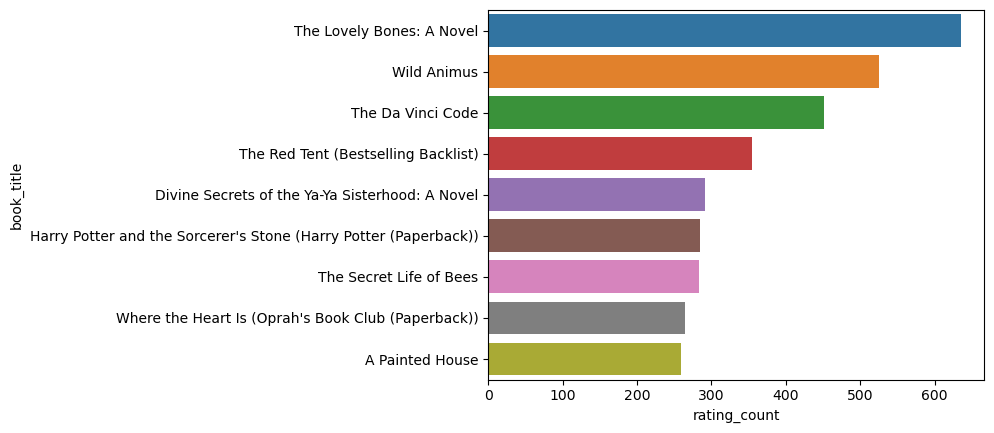

In [36]:
# Barplot for feature 'book_title'
sns.barplot(y='book_title', x='rating_count', data=top_rated_books)

<Figure size 1600x800 with 0 Axes>

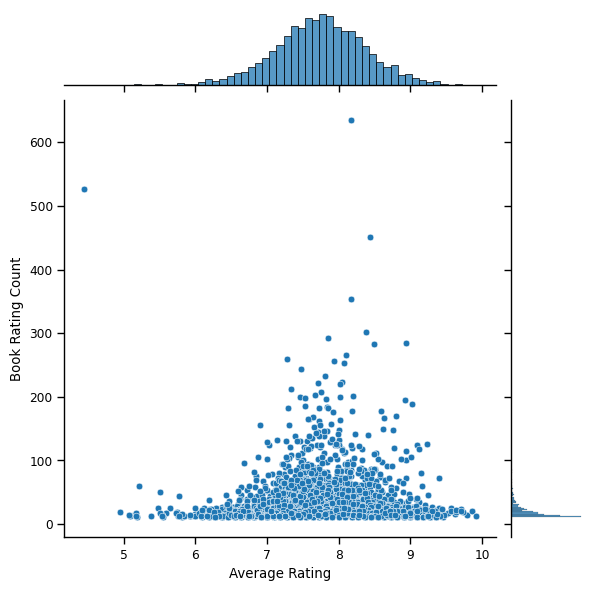

In [37]:
#Checking for any relation between them.
plt.figure(figsize=(16,8))
sns.set_context('paper')
ax = sns.jointplot(x="rating_mean",y='rating_count', kind='scatter', data= agg_rating_GT10_count_df[['rating_mean', 'rating_count']])
ax.set_axis_labels("Average Rating", "Book Rating Count")
plt.show()

### 3.6: Creating Final DataFrame

In [38]:
# Merge both dataframe book_rating_GT10_count_df, agg_user_GT2_book_count_df into single dataframe.
# Store the final dataframe inside final_book_rating_df
final_book_rating_df = pd.merge(book_rating_GT10_count_df, agg_user_GT2_book_count_df[['user_id']], on=['user_id'], how='inner')

In [39]:
# Print first 5 rows of the final dataset
final_book_rating_df.head()

,user_id,isbn,rating
0,243,155874262X,5
1,243,316601950,9
2,243,60977493,7
3,243,316776963,9
4,243,044023722X,7


In [40]:
# Print the size of the final dataset
final_book_rating_df.shape

(70947, 3)

In [41]:
# Number of users
print('The final book ratings dataset has', final_book_rating_df['user_id'].nunique(), 'unique users')

# Number of books
print('The final book ratings dataset has', final_book_rating_df['isbn'].nunique(), 'unique isbn')

# Number of ratings
print('The final boook ratings dataset has', final_book_rating_df['rating'].nunique(), 'unique ratings')

# List of unique ratings
print('The unique ratings are', sorted(final_book_rating_df['rating'].unique()))

The final book ratings dataset has 4139 unique users
The final book ratings dataset has 4427 unique isbn
The final boook ratings dataset has 10 unique ratings
The unique ratings are [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


### 3.7: Create Ordered Integer Identifiers For User and Isbn

In [42]:
# Create new ordered integer identifiers from user_id by using category codes
final_book_rating_df["user_index"] = final_book_rating_df["user_id"].astype("category").cat.codes

In [43]:
# Create new ordered integer identifiers from isbn by using category codes
final_book_rating_df["book_index"] = final_book_rating_df["isbn"].astype("category").cat.codes

In [44]:
# Print first 5 rows of the final dataset after adding two integer identifiers columns
final_book_rating_df.head()

,user_id,isbn,rating,user_index,book_index
0,243,155874262X,5,0,546
1,243,316601950,9,0,835
2,243,60977493,7,0,3269
3,243,316776963,9,0,859
4,243,044023722X,7,0,185


In [45]:
# Aggrigate book-index and user-index
final_book_rating_df.agg({'book_index':['min', 'max', 'count'], 'user_index':['min', 'max', 'count']})

,book_index,user_index
min,0,0
max,4426,4138
count,70947,70947


Observation:
* user-index has orderd valeus from 0 upto 4426
* book-index has orderd values from 0 upto 4138 

In [46]:
final_book_rating_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 70947 entries, 0 to 70946
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     70947 non-null  int64 
 1   isbn        70947 non-null  object
 2   rating      70947 non-null  int64 
 3   user_index  70947 non-null  int16 
 4   book_index  70947 non-null  int16 
dtypes: int16(2), int64(2), object(1)
memory usage: 2.4+ MB


Observation: 
* There are 5 variables in the final_book_rating_df dataframe. 
* There are 70,947 rows of data

In [47]:
# Get list of isbn by book indexs
def get_book_isbn_by_indexs(book_indexs):
    '''Find books by index and returns an array of thier Isbn.'''
    book_isbns = final_book_rating_df[final_book_rating_df["book_index"].isin(book_indexs)][["isbn","book_index"]]
    book_isbns = book_isbns.drop_duplicates()

    return book_isbns

# Get an array of book title by book-isbn
def get_book_title_by_isbns(book_isbns):
    '''Find books by isbn and returns an array of thier title.'''
    book_titles = book_df[book_df["isbn"].isin(book_isbns)][['isbn', 'book_title']]

    return book_titles

# get book detail with book indexs
def get_detail_of_books(book_indexs):
    # Get books isbn
    book_isbns = get_book_isbn_by_indexs(book_indexs)

    # Get books title
    book_titles = get_book_title_by_isbns(book_isbns['isbn'].tolist())

    # Merge isbn and title
    return pd.merge(book_isbns, book_titles[['isbn','book_title']], on=['isbn'], how='inner')

## Step 4: Create Book-User Matrix

In [48]:
# Create book-user matrix
user_book_matrix = final_book_rating_df.pivot_table(index='book_index', columns='user_index', values='rating')

In [49]:
# Print the first 5 rows of the matrix
user_book_matrix.head()

user_index,0,1,2,3,4,5,6,7,8,9,...,4129,4130,4131,4132,4133,4134,4135,4136,4137,4138
book_index,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Observation:
* The dataset transformed into a matrix format. The rows of the matrix are books and the columns of the matrix are users
* The value of the matrix is the user rating of the book if the user has rated of the book else it set to null.

## Step 5: Data Normalization

In [50]:
# Normalize user-item matrix
normalize_user_book_matrix = user_book_matrix.subtract(user_book_matrix.mean(axis=1), axis = 'rows')
normalize_user_book_matrix.head()

user_index,0,1,2,3,4,5,6,7,8,9,...,4129,4130,4131,4132,4133,4134,4135,4136,4137,4138
book_index,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Observation:
* The rating normalized by extracting the average rating of each book.
* After normalization, the book with a rating less than the book's average rating get a negative value,
* And the book with a rating more than the book's average rating get a positive value.

## Step 6: Calculate Similarity Score

In [51]:
# Create item similarity matrix using Pearson correlation
book_similarity = normalize_user_book_matrix.T.corr()

In [52]:
# the size of the similarity matrix
book_similarity.shape

(4427, 4427)

In [53]:
# Print the first 5 rows of the matrix
book_similarity.head()

book_index,0,1,2,3,4,5,6,7,8,9,...,4417,4418,4419,4420,4421,4422,4423,4424,4425,4426
book_index,,,,,,,,,,,,,,,,,,,,,
0,1.000000,NaN,-0.866025,0.5,NaN,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,-0.944911,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-0.866025,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,-1.0,NaN,0.755929,1.0,NaN,NaN,NaN,NaN,NaN
3,0.500000,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Observation:
* We used Pearson correlation similarity method to measure similarities.

## Step 7: Predict User's Rating For One Book

In [54]:
# Pick a user ID
picked_user_index = 0

# Pick a movie
picked_book_index = 1974 # ISBN: '440211727' | Book title: A Time to Kill

# Top number of similar book
top_num_of_sim_book = 5

In [55]:
# Books that the target user has read
picked_user_read = pd.DataFrame(normalize_user_book_matrix[picked_user_index].dropna(axis=0, how='all')
                          .sort_values(ascending=False))\
                          .reset_index()\
                          .rename(columns={picked_user_index:'rating'})

# Get detail info of books
book_detail = get_detail_of_books(picked_user_read['book_index'].tolist())

# Merge book detail
picked_user_read = pd.merge(picked_user_read, book_detail[['book_index','isbn','book_title']], on=['book_index'], how='inner')

picked_user_read.head()

,book_index,rating,isbn,book_title
0,835,1.460938,316601950,The Pilot's Wife : A Novel
1,3218,1.430769,60915544,The Bean Trees
2,1254,1.360000,375400117,Memoirs of a Geisha
3,1824,1.113636,425163407,Unnatural Exposure
4,2195,1.000000,446364800,The General's Daughter


Observation:
* We can see that user 0's favorite is 'The Pilot's Wife' and 'The Bean Trees' followed by Memoirs of a Geisha.

In [56]:
# Similarity score of the book 'A Time to Kill' with all the other books
picked_book_sim_score = book_similarity[[picked_book_index]].reset_index()\
                            .rename(columns={picked_book_index:'score'})

# Rank the similarities between the books user 0 rated and 'A Time to Kill'.
picked_user_read_sim = pd.merge(picked_user_read, picked_book_sim_score, 
                                   on='book_index', 
                                   how='inner')\
                                   .sort_values('score', ascending=False)[:top_num_of_sim_book]

# Take a look at the User 0 read books with highest similarity
picked_user_read_sim

,book_index,rating,isbn,book_title,score
8,1599,-0.035088,385720106,A Map of the World,0.989743
3,1824,1.113636,425163407,Unnatural Exposure,0.981981
10,185,-0.528455,044023722X,A Painted House,0.842923
7,880,0.125000,316899984,"River, Cross My Heart",0.500000
0,835,1.460938,316601950,The Pilot's Wife : A Novel,0.488504


Observation:
* We can see the similarity score of the book 'A Time to Kill' with the book user 0 has read.
* And pick the top 5 books with the highest similarity score.

In [57]:
# Calculate the predicted rating using weighted average of similarity scores and the ratings from user 0
predicted_rating = round(np.average(picked_user_read_sim['rating'],weights=picked_user_read_sim['score']), 6)

print(f'The predicted rating for {picked_book_index} by user {picked_user_index} is {predicted_rating}' )

The predicted rating for 1974 by user 0 is 0.365373


## Step 8: Book Recommendation

In step 8, we will create an item-item book recommendation system following four steps:
1. Create a list of book that the target user has not read before.
2. Loop through the unread book and create predicted scores for each book.
3. Rank the predicted score of unread book from high to low.
4. Select the top N book as the recommendations for the target user.

In [58]:
# Item-based recommendation function
def item_based_recommender(picked_user_index=0, num_of_sim_books=5, top_num_of_reco=5):
  
  # Books that the target user has not read
  picked_user_unread = pd.DataFrame(normalize_user_book_matrix[picked_user_index].isna()).reset_index()
  picked_user_unread = picked_user_unread[picked_user_unread[picked_user_index]==True]['book_index'].values.tolist()

  # Movies that the target user has watched
  picked_user_read = pd.DataFrame(normalize_user_book_matrix[picked_user_index].dropna(axis=0, how='all')\
                            .sort_values(ascending=False))\
                            .reset_index()\
                            .rename(columns={picked_user_index:'rating'})
  
  # Dictionary to save the unread book and predicted rating
  rating_prediction ={}  

  # Loop through unread books          
  for book_index in picked_user_unread: 
    
    # Calculate the similarity score of the picked book with other books
    picked_book_sim_score = book_similarity[[book_index]].reset_index().rename(columns={book_index:'score'})
    
    # Rank the similarities between the picked user watched movie and the picked unwatched movie.
    picked_book_sim_score = pd.merge(left=picked_user_read,right=picked_book_sim_score, 
                                      on='book_index', 
                                      how='inner')\
                                      .sort_values('score', ascending=False)[:num_of_sim_books]

    # Calculate the predicted rating using weighted average of similarity scores and the ratings from user 0
    predicted_rating = round(np.average(picked_book_sim_score['rating'],weights=picked_book_sim_score['score']), 6)

    # If predicted rating has value save in the dictionary
    if np.isnan(predicted_rating) == False:
      rating_prediction[book_index] = predicted_rating

  # Return the top recommended books
  return sorted(rating_prediction.items(), key=operator.itemgetter(1), reverse=True)[:top_num_of_reco]

In [59]:
# Get the recommendations
recommended_book = item_based_recommender(picked_user_index, top_num_of_sim_book, 5)

# Convert dictionary to pandas dataframe
recommended_book_df = pd.DataFrame(recommended_book, columns=['book_index', 'book_score'])

In [60]:
# Get deatil information of recommeded books
book_detail = get_detail_of_books(recommended_book_df['book_index'].tolist())

# Merge book detail
recommended_book_df = pd.merge(recommended_book_df, book_detail[['book_index','isbn', 'book_title']], 
                                on=['book_index'], 
                                how='inner')

# Print recommende books
recommended_book_df

,book_index,book_score,isbn,book_title
0,317,143.604837,074322535X,Gap Creek: The Story of a Marriage
1,4058,51.618049,767900383,Under the Tuscan Sun
2,2271,41.571620,446605484,Roses Are Red (Alex Cross Novels)
3,4115,24.969891,786868619,Stolen Lives: Twenty Years in a Desert Jail
4,2981,16.398929,553560247,Dying for Chocolate (Culinary Mysteries (Paper...


## Step 9: Cross Validation

In [61]:
# Initialize Reader classs
reader = sr.Reader(rating_scale=(1, 10))

# To load custom dataset that store in final_book_rating_df dataframe
data = sd.Dataset.load_from_df(final_book_rating_df[["book_index", "user_index", "rating"]], reader)

In [62]:
# Split train test
trainset, testset = train_test_split(data, test_size = .25, random_state=10)

In [63]:
sim_options = {'name': 'cosine','user_based': False}
algo = KNNBasic(sim_options=sim_options)

# Train the algorithm on the trainset, and predict ratings for the testset
predictions = algo.fit(trainset).test(testset)

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [64]:
# Then compute RMSE
mae = accuracy.mae(predictions)
rmse = accuracy.rmse(predictions)

MAE:  1.4808
RMSE: 1.9087


In [65]:
result = pd.DataFrame(predictions, columns=["user_index", "book_index", "base_event", 'predict_event', 'details'])
result.drop(columns = {'details'}, inplace = True)
result['erro'] = abs(result['base_event'] - result['predict_event'])
result.head()

,user_index,book_index,base_event,predict_event,erro
0,1955,132,5.0,7.359696,2.359696
1,2624,1366,9.0,7.972287,1.027713
2,4116,640,4.0,8.333333,4.333333
3,2547,1197,8.0,6.500000,1.500000
4,328,156,8.0,8.096193,0.096193
